In [2]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
!pip install roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 8.8 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.8.1.78
    Uninstalling opencv-python-headless-4.8.1.78:
      Successfully uninstall

In [4]:
from roboflow import Roboflow
rf = Roboflow(api_key="y4P6GcSkqbqyTkiG8UHR")
project = rf.workspace("tugas-akhir-sbmnz").project("traffic-signs-t0xit")
dataset = project.version(2).download("coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Traffic-signs-2 in coco:: 100%|██████████| 4323/4323 [00:02<00:00, 1625.25it/s]


In [5]:
# Load the MobileNetV2 base model
base_model = MobileNetV2(weights='imagenet', include_top=False)

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.0001))(x)
x = BatchNormalization(moving_mean_initializer='zeros', moving_variance_initializer='zeros')(x)
x = Dropout(0.5)(x)  # Add dropout with a dropout rate of 0.5
x = Dense(256, activation='relu', kernel_regularizer=l2(0.0001))(x)
x = BatchNormalization(moving_mean_initializer='zeros', moving_variance_initializer='zeros')(x)
x = Dropout(0.5)(x)  # Add dropout with a dropout rate of 0.5
x = Dense(128, activation='relu', kernel_regularizer=l2(0.0001))(x)
x = BatchNormalization(moving_mean_initializer='zeros', moving_variance_initializer='zeros')(x)
x = Dropout(0.5)(x)  # Add dropout with a dropout rate of 0.5
predictions = Dense(18, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


9406464/9406464 [==============================] - 0s 0us/step


In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, None, None, 32)       128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, None, None, 32)       0         ['bn_Conv1[0][0]']        

In [7]:
# Unfreeze the first 3 layers and last 5 layers, freeze the rest
for layer in model.layers[:3] + model.layers[-11:]:
    layer.trainable = True

for layer in model.layers[3:-11]:
    layer.trainable = False


In [8]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, None, None, 32)       128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, None, None, 32)       0         ['bn_Conv1[0][0]']        

In [10]:
import os
import json
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil  # Import shutil for the move operation

# Function to move files to class subdirectories
def move_files_to_subdirectories(df, dataset_dir):
    for _, row in df.iterrows():
        source_path = row['filename']
        class_name = row['class']
        destination_path = os.path.join(dataset_dir, class_name, os.path.basename(source_path))

        try:
            shutil.move(source_path, destination_path)
        except FileNotFoundError as e:
            print(f"Error moving file: {e}")
            print(f"Source path: {source_path}")
            print(f"Destination path: {destination_path}")


# Define the parse_coco_annotations function
def parse_coco_annotations(annotation_path):
    with open(annotation_path, 'r') as f:
        coco_data = json.load(f)

    annotations = coco_data['annotations']
    image_id_to_category_id = {ann['image_id']: ann['category_id'] for ann in annotations}

    return image_id_to_category_id

# Function to create class subdirectories
def create_class_subdirectories(dataset_dir, class_names):
    for class_name in class_names:
        class_dir = os.path.join(dataset_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)

# Path to the directory containing images and COCO annotation files
train_dir = '/content/Traffic-signs-2/train'

# Get subdirectories (class names)
subdirectories = [
    'peringatan-banyak-pejalan-kaki-menggunakan-zebra-cross',
    'peringatan-simpang-tiga-sisi-kiri',
    'larangan-masuk-bagi-kendaraan-bermotor-dan-tidak-bermotor',
    'larangan-berhenti',
    'peringatan-penegasan-rambu-tambahan',
    'larangan-parkir',
    'peringatan-pintu-perlintasan-kereta-api',
    'petunjuk-penyeberangan-pejalan-kaki',
    'larangan-belok-kiri',
    'perintah-pilihan-memasuki-salah-satu-jalur',
    'peringatan-alat-pemberi-isyarat-lalu-lintas',
    'larangan-memutar-balik',
    'perintah-masuk-jalur-kiri',
    'larangan-berjalan-terus-wajib-berhenti-sesaat',
    'petunjuk-lokasi-putar-balik',
    'petunjuk-lokasi-pemberhentian-bus',
    'petunjuk-area-parkir',
    'larangan-belok-kanan'
]

# Create class subdirectories
create_class_subdirectories(train_dir, subdirectories)

# Set up data generator
datagen = ImageDataGenerator(rescale=1./255)

# Create a DataFrame with file paths and class labels
image_files = []
class_labels = []

for root, dirs, files in os.walk(train_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_files.append(os.path.join(root, file))
            image_id = file.split('.')[0]  # Use the entire file name without extension

            # Check which class subdirectory the image belongs to
            for class_name in subdirectories:
                if class_name in image_id:
                    class_labels.append(class_name)
                    break
            else:
                class_labels.append('-1')  # If not found in any class, label as '-1'

df = pd.DataFrame({'filename': image_files, 'class': class_labels})

move_files_to_subdirectories(df, train_dir)

In [11]:
# Set up data generator for validation
validation_datagen = ImageDataGenerator(rescale=1./255)

# Path to the directory containing validation images and COCO annotation files
validation_dir = '/content/Traffic-signs-2/valid'

# Create class subdirectories for validation
create_class_subdirectories(validation_dir, subdirectories)

# Create a DataFrame for validation set
validation_image_files = []
validation_class_labels = []

for root, dirs, files in os.walk(validation_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            validation_image_files.append(os.path.join(root, file))
            image_id = file.split('.')[0]  # Use the entire file name without extension

            # Check which class subdirectory the image belongs to
            for class_name in subdirectories:
                if class_name in image_id:
                    validation_class_labels.append(class_name)
                    break
            else:
                validation_class_labels.append('-1')  # If not found in any class, label as '-1'

validation_df = pd.DataFrame({'filename': validation_image_files, 'class': validation_class_labels})
# Move files to class subdirectories
move_files_to_subdirectories(validation_df, validation_dir)

In [12]:
# Set up data generator
train_generator = datagen.flow_from_directory(
    '/content/Traffic-signs-2/train',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=True,
)

# Set up data generator for validation
validation_generator = validation_datagen.flow_from_directory(
    '/content/Traffic-signs-2/valid',
    target_size=(224, 224),
    batch_size=20,
    class_mode='categorical',
    shuffle=False,  # Set to False to keep the order of images for evaluation
)


Found 3777 images belonging to 18 classes.
Found 360 images belonging to 18 classes.


Epoch 1/50
60/60 [==============================] - 41s 364ms/step - loss: 3.0582 - accuracy: 0.2121 - val_loss: 4.1760 - val_accuracy: 0.3806
Epoch 2/50
60/60 [==============================] - 21s 350ms/step - loss: 1.8329 - accuracy: 0.4493 - val_loss: 1.7808 - val_accuracy: 0.4944
Epoch 3/50
60/60 [==============================] - 20s 339ms/step - loss: 1.4085 - accuracy: 0.5661 - val_loss: 1.2968 - val_accuracy: 0.5750
Epoch 4/50
60/60 [==============================] - 22s 358ms/step - loss: 1.1644 - accuracy: 0.6444 - val_loss: 1.0398 - val_accuracy: 0.6472
Epoch 5/50
60/60 [==============================] - 20s 332ms/step - loss: 1.0633 - accuracy: 0.6863 - val_loss: 0.9963 - val_accuracy: 0.6694
Epoch 6/50
60/60 [==============================] - 21s 343ms/step - loss: 0.9045 - accuracy: 0.7427 - val_loss: 1.0239 - val_accuracy: 0.6722
Epoch 7/50
60/60 [==============================] - 21s 346ms/step - loss: 0.7957 - accuracy: 0.7763 - val_loss: 1.0281 - val_accuracy: 0.6528

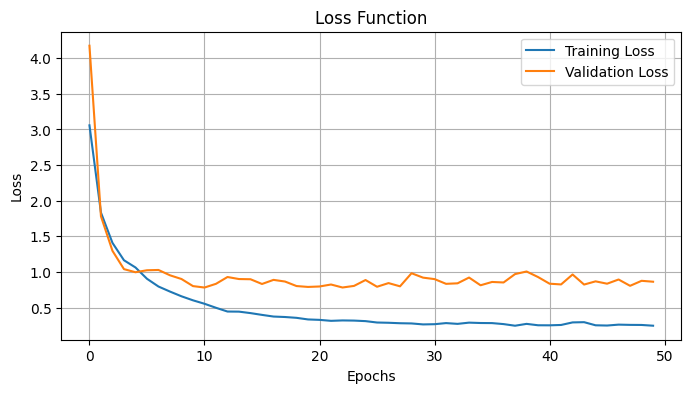

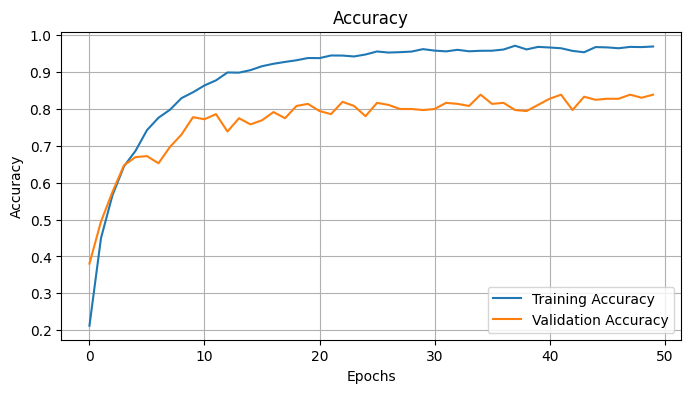

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator
)

# Plot the training and validation loss
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Function')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [14]:
model.save("MobilenetV2_TrafficSign.h5")
model.save('MobileNetV2_TrafficSign.keras')

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


1/1 [==============================] - 0s 337ms/step
Predicted class index: 16


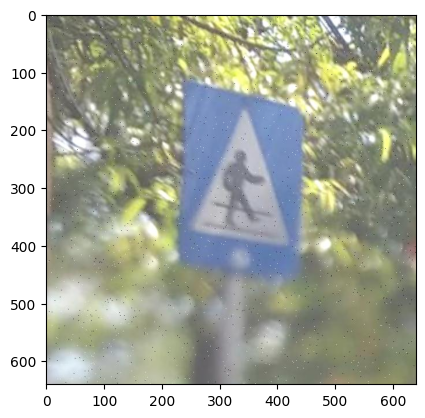

In [18]:
from tensorflow import keras
import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model

image = '/Users/albagir/Desktop/FinalProject/Traffic-signs-2/train/images/petunjuk-penyeberangan-pejalan-kaki-95-_jpg.rf.94cb618b929a492db45d923c249bfa80.jpg'
im = cv2.imread(image)
rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
numpy_array = np.array(rgb)
model = load_model('/Users/albagir/Desktop/FinalProject/Models/MobileNetV2_TrafficSign.keras')
plt.imshow(numpy_array)
# Resize the image to match the expected input shape of the model
resized_image = cv2.resize(rgb, (250, 250))
# Add an extra dimension to create a batch of images
image_batch = np.expand_dims(resized_image, axis=0)

# Preprocess the image according to the needs of your model
processed_image = keras.applications.mobilenet_v2.preprocess_input(image_batch)


predictions = model.predict(processed_image)
predicted_class_index = np.argmax(predictions)
print("Predicted class index:", predicted_class_index)


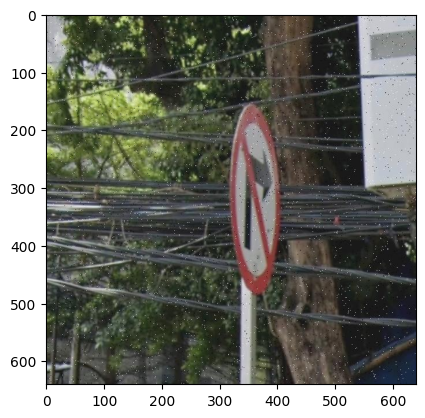

1/1 [==============================] - 0s 355ms/step
Predicted class: warning - 3 way junction
Prediction scores: [3.4443766e-02 2.2356185e-01 1.5870426e-03 7.1669975e-04 1.6668357e-02
 8.7084126e-04 1.7429520e-03 4.0525962e-02 2.2560928e-04 1.2921688e-01
 1.6334895e-03 5.1823276e-01 2.2970016e-04 1.6846543e-02 9.5465053e-03
 2.8828774e-03 3.1899815e-04 7.4911688e-04]


In [24]:
from tensorflow import keras
import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model

def get_predicted_class(model, image_path, class_labels):
    # Load and preprocess the image
    im = cv2.imread(image_path)
    rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(rgb, (250, 250))
    image_batch = np.expand_dims(resized_image, axis=0)
    processed_image = keras.applications.mobilenet_v2.preprocess_input(image_batch)

    # Make predictions
    predictions = model.predict(processed_image)

    # Get the predicted class index
    predicted_class_index = np.argmax(predictions)

    # Get the predicted class label
    predicted_class_label = class_labels.get(predicted_class_index, "Unknown")

    return predicted_class_label, predictions[0]

# Load the image
image_path = '/Users/albagir/Desktop/FinalProject/Traffic-signs-2/train/images/larangan-belok-kanan-87-_jpg.rf.7d5c63910d3dfe6f37f4e9c882f47e9d.jpg'
class_labels = {
    0: 'prohibition - No turning right',
    1: 'peringatan-simpang-tiga-sisi-kiri',
    2: 'larangan-masuk-bagi-kendaraan-bermotor-dan-tidak-bermotor',
    3: 'larangan-berhenti',
    4: 'peringatan-penegasan-rambu-tambahan',
    5: 'larangan-parkir',
    6: 'peringatan-pintu-perlintasan-kereta-api',
    7: 'petunjuk-penyeberangan-pejalan-kaki',
    8: 'larangan-belok-kiri',
    9: 'perintah-pilihan-memasuki-salah-satu-jalur',
    10: 'peringatan-alat-pemberi-isyarat-lalu-lintas',
    11: 'warning - 3 way junction',
    12: 'perintah-masuk-jalur-kiri',
    13: 'larangan-berjalan-terus-wajib-berhenti-sesaat',
    14: 'petunjuk-lokasi-putar-balik',
    15: 'petunjuk-lokasi-pemberhentian-bus',
    16: 'petunjuk-area-parkir',
    17: 'larangan-belok-kanan'
}

# Load the pre-trained model
model_path = '/Users/albagir/Desktop/FinalProject/Models/MobileNetV2_TrafficSign.keras'
model = load_model(model_path)

# Display the image
im = cv2.imread(image_path)
rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(rgb)
plt.show()

# Get the predicted class and prediction scores
predicted_class, prediction_scores = get_predicted_class(model, image_path, class_labels)

print("Predicted class:", predicted_class)
print("Prediction scores:", prediction_scores)
